In [22]:
import sys
stdout = sys.stdout
reload(sys)
sys.setdefaultencoding('utf-8')
sys.stdout = stdout

import glob,os,pickle
import numpy as np
from netCDF4 import Dataset,netcdftime,num2date
import pandas as pd
import matplotlib.pylab as plt
from colour import Color

sys.path.append('/Users/peterpfleiderer/Documents/Projects/country_analysis/country_analysis_scripts/')
import country_analysis; reload(country_analysis)

os.chdir('/Users/peterpfleiderer/Documents/Projects/')

COU=country_analysis.country_analysis('SEN','country_analysis/data/SEN_complete/',seasons={'annual':range(1,13)},additional_tag='_complete')
COU.load_data()
COU.unit_conversions()

In [27]:
# plot settings

plot_dict={24:{'label':'CORDEX','color':'gray'},
           19:{'label':'CORDEX_BC','color':'red'},
           1:{'label':'CMIP5_BC','color':'green'},
           28:{'label':'EWEMBI','color':'blue'},
          }


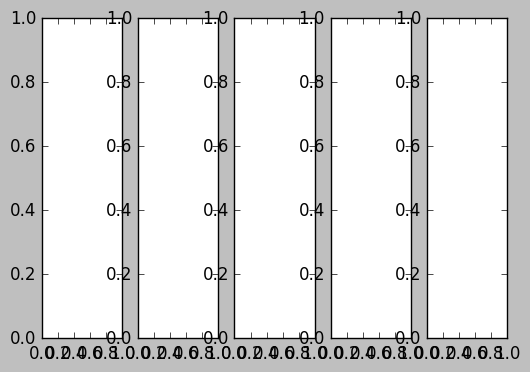

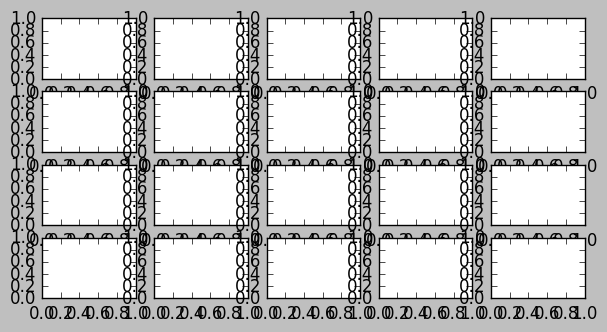

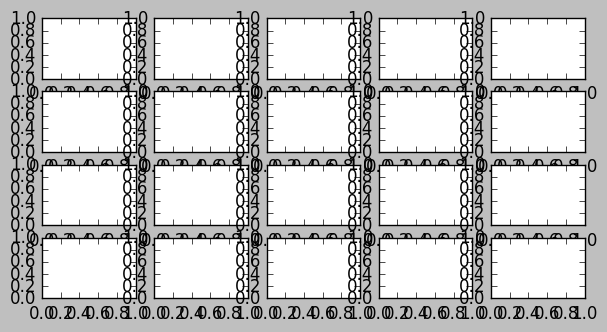

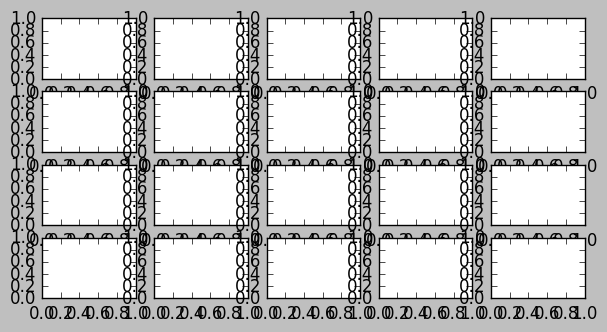

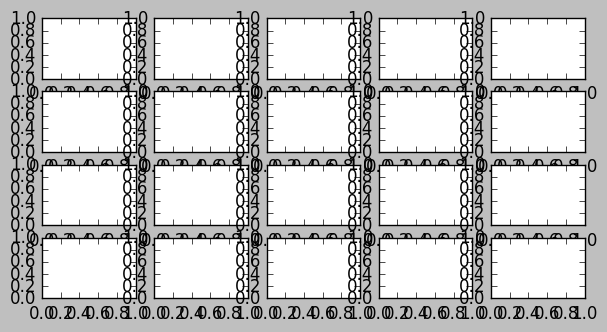

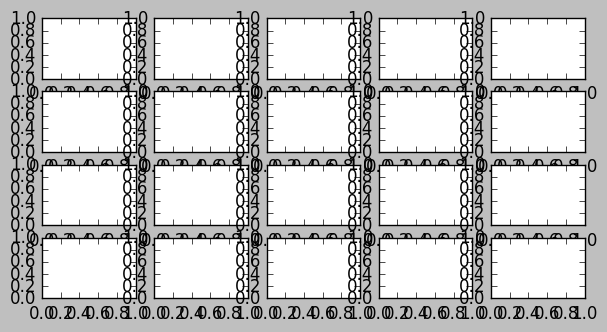

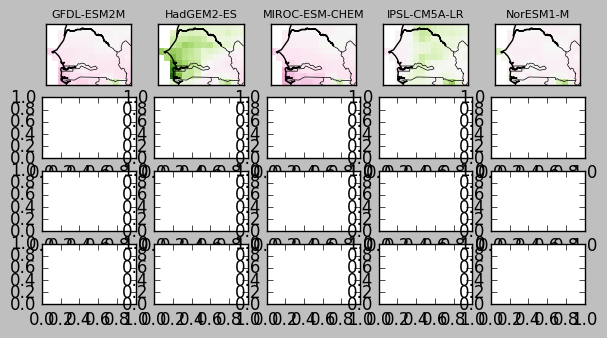

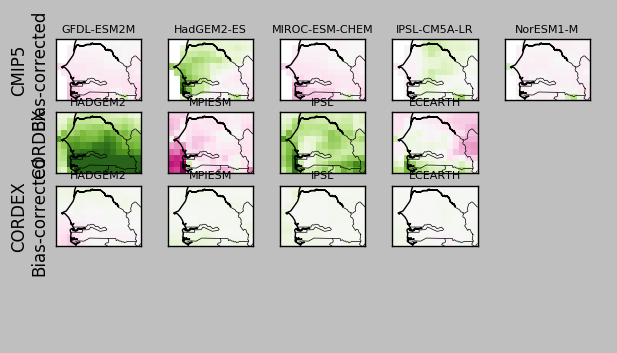

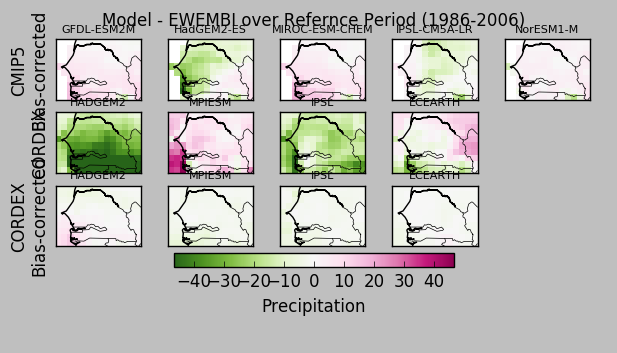

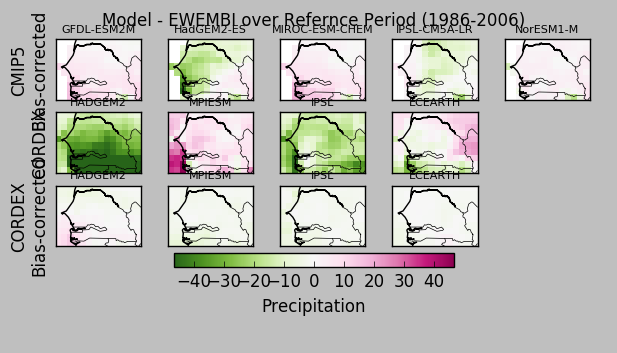

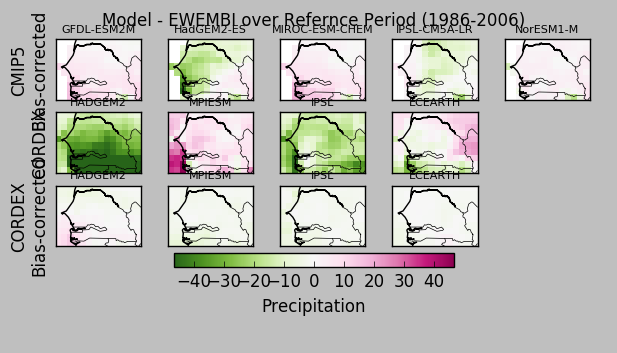

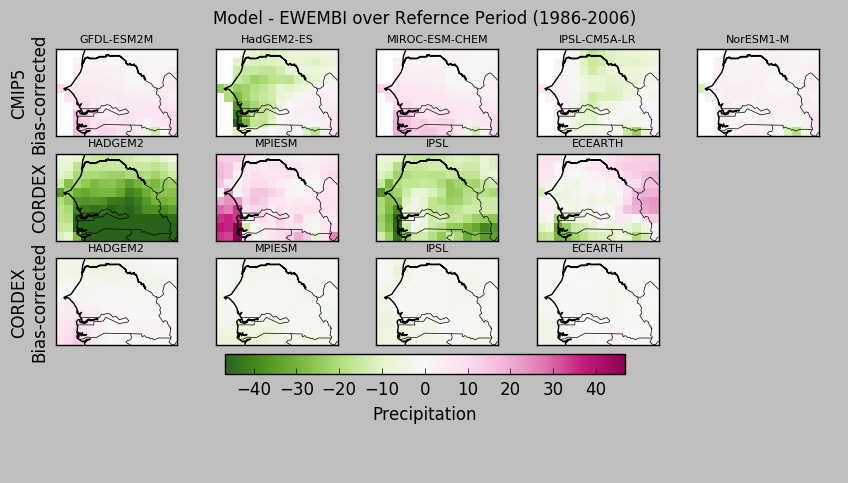

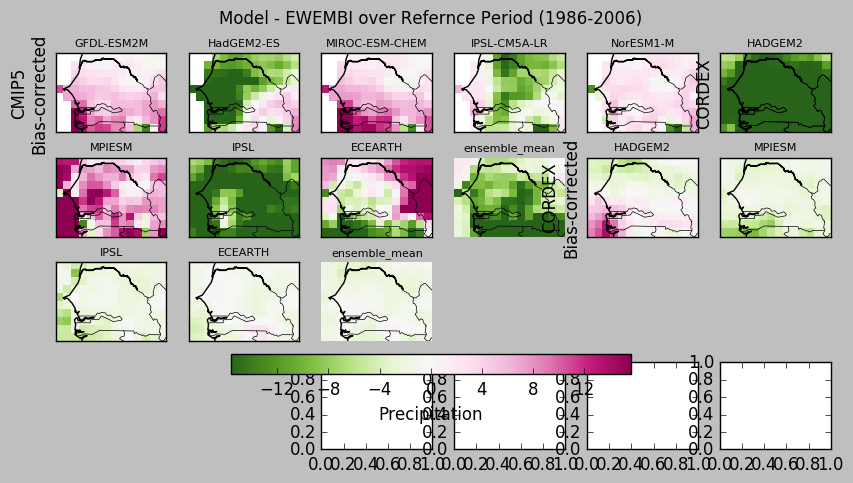

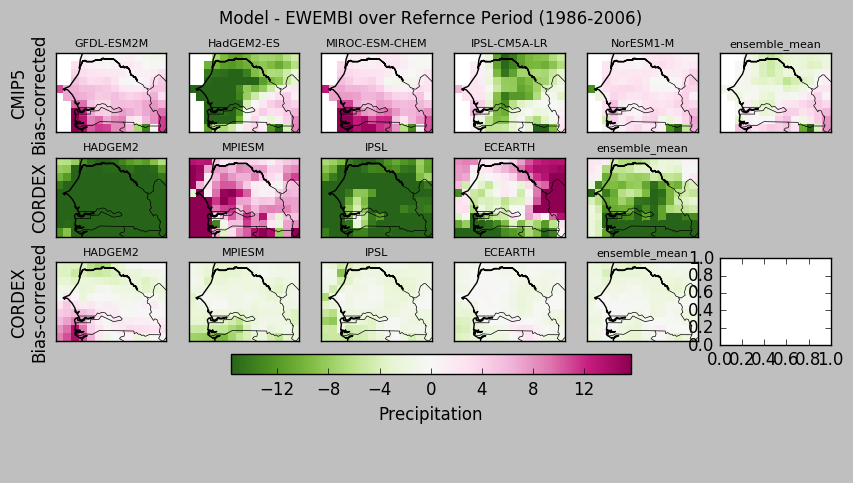

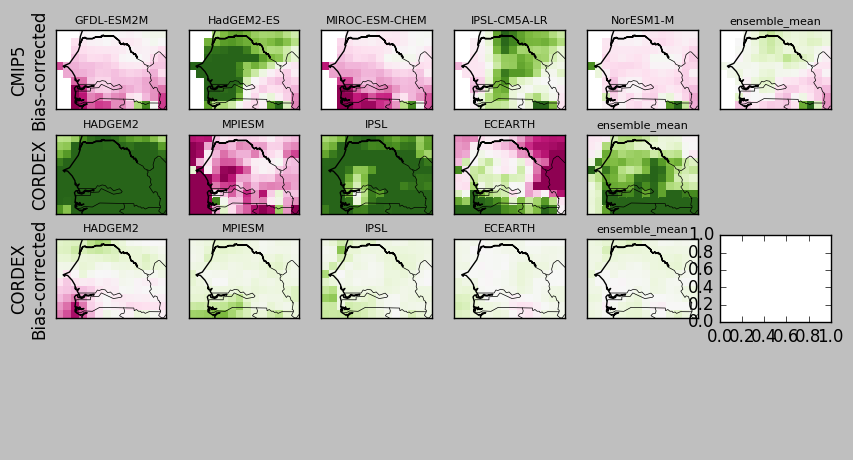

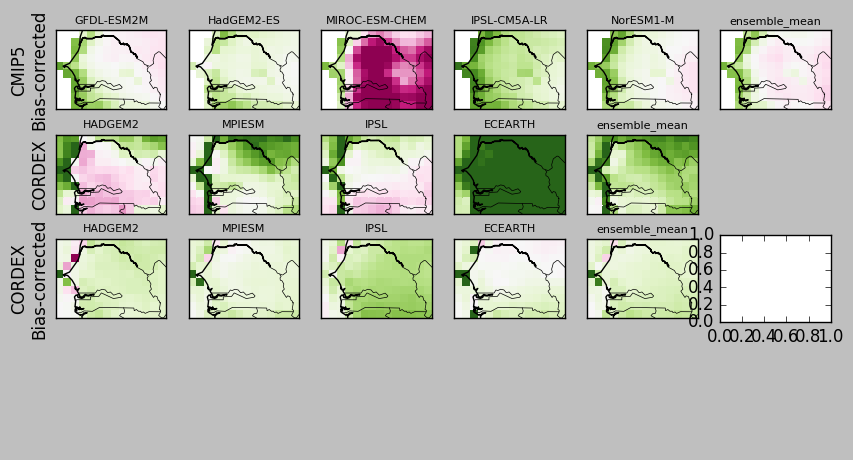

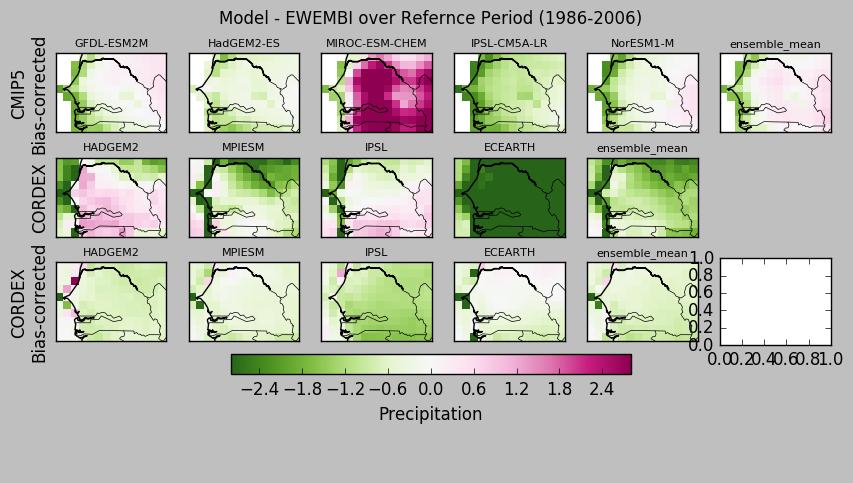

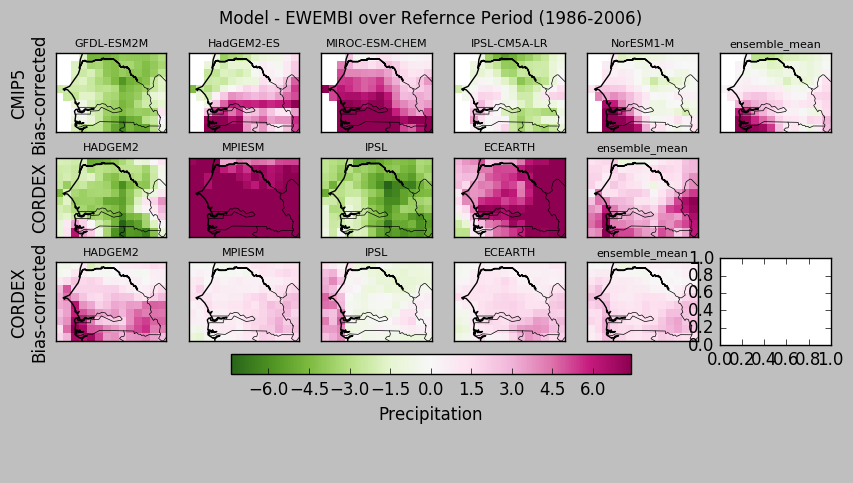

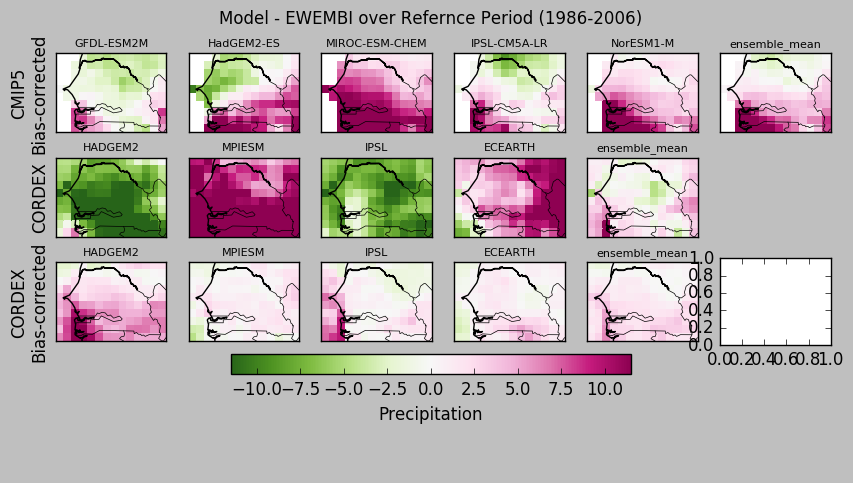

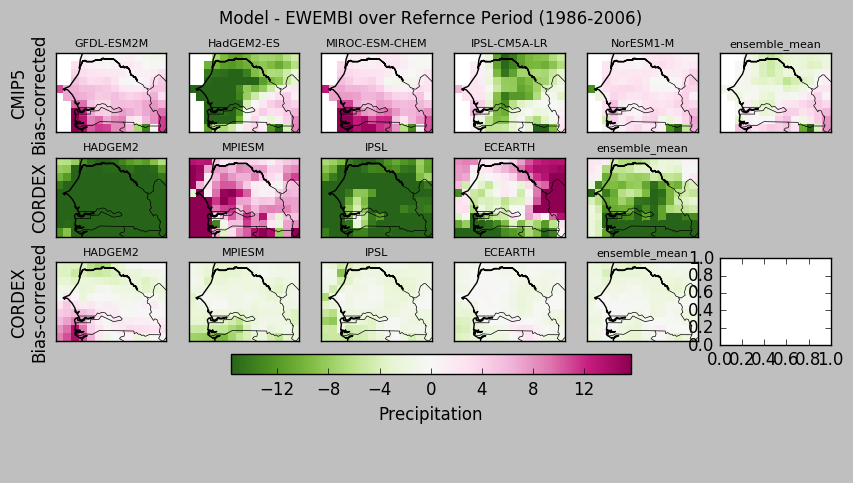

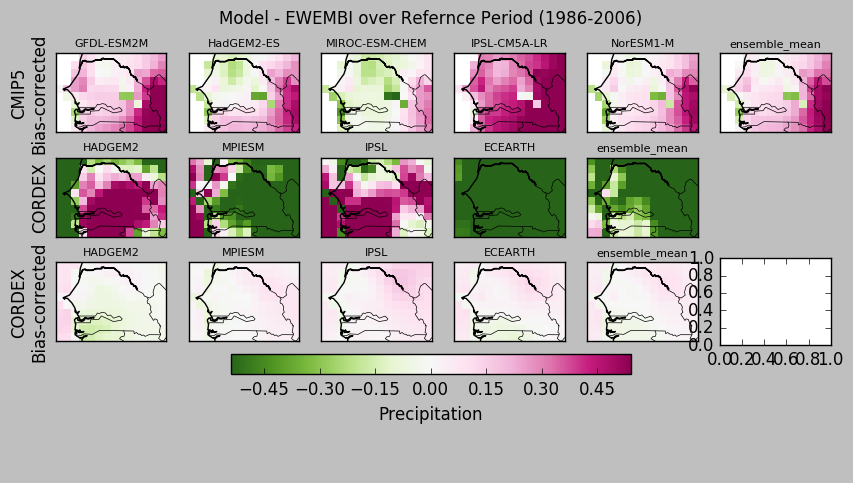

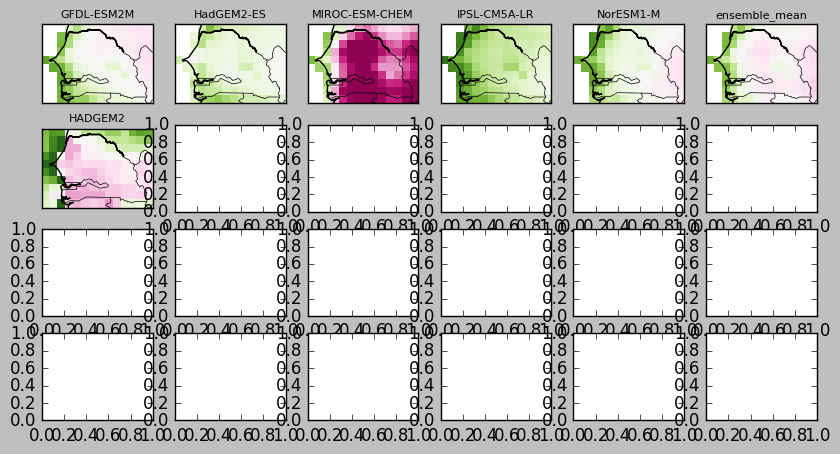

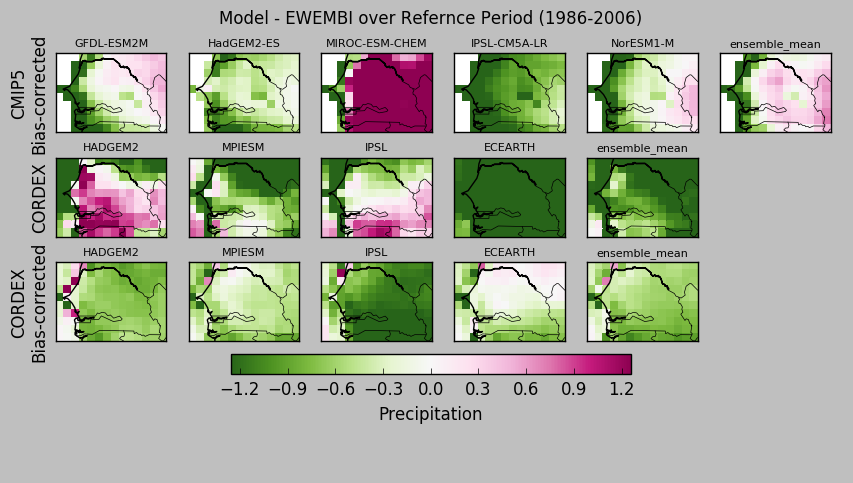

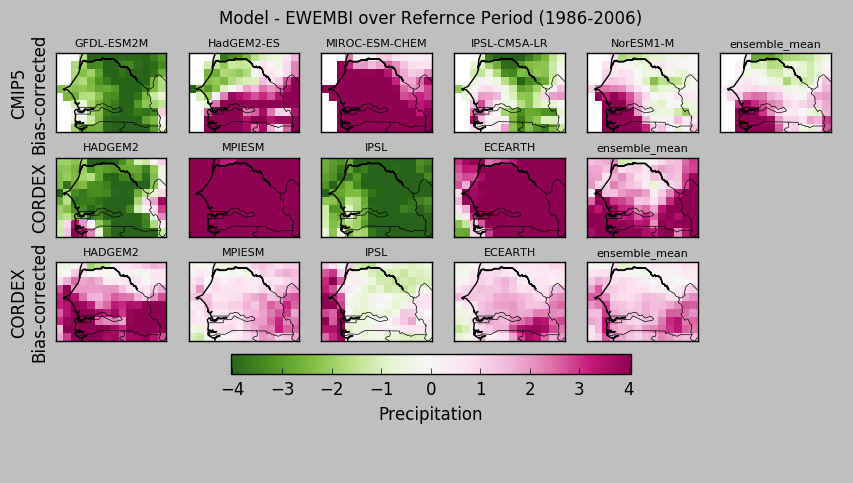

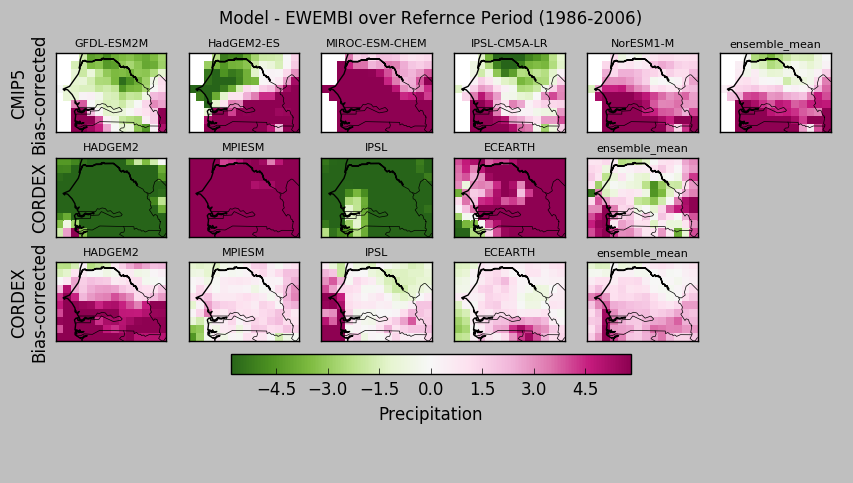

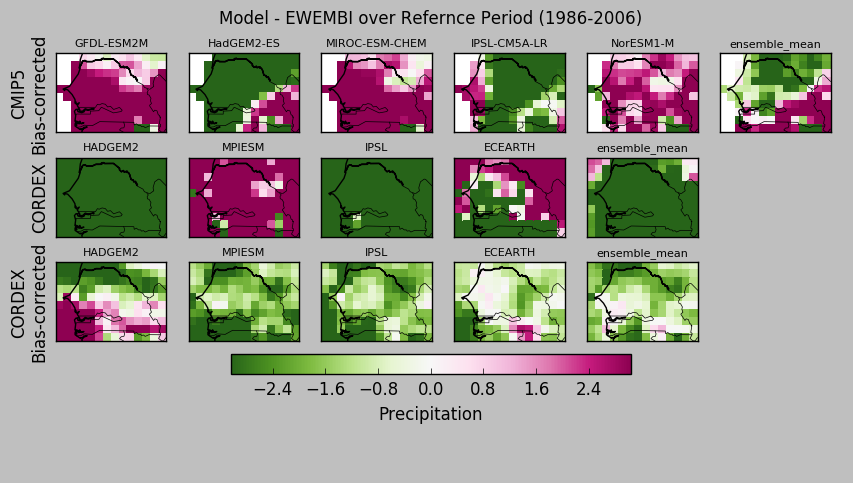

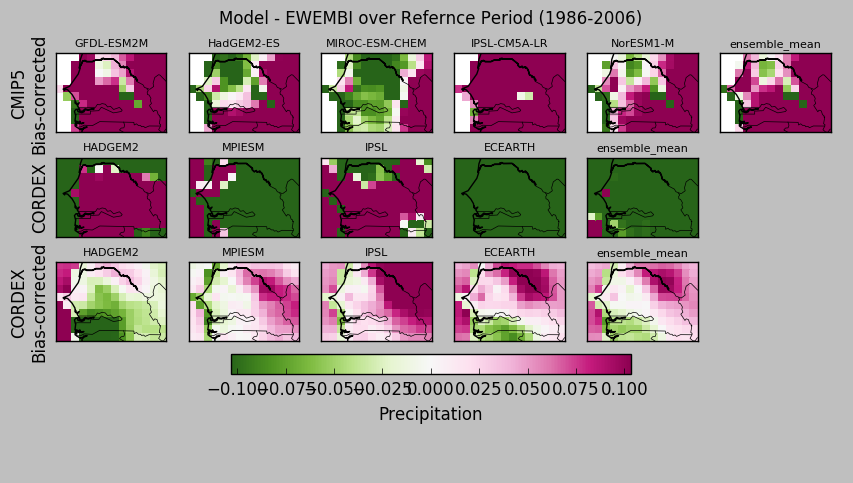

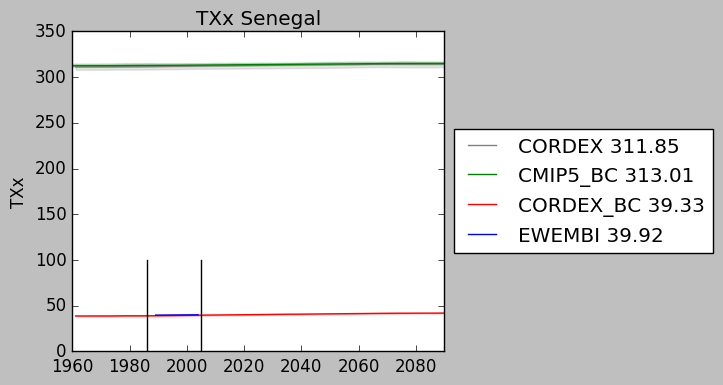

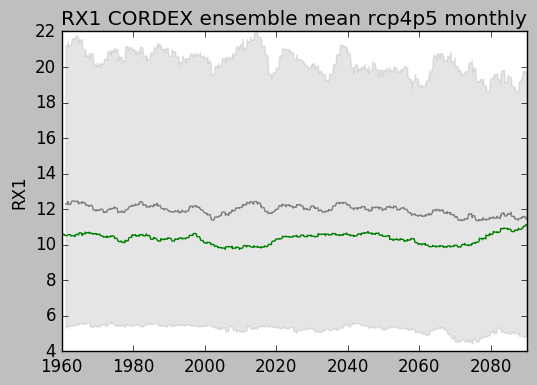

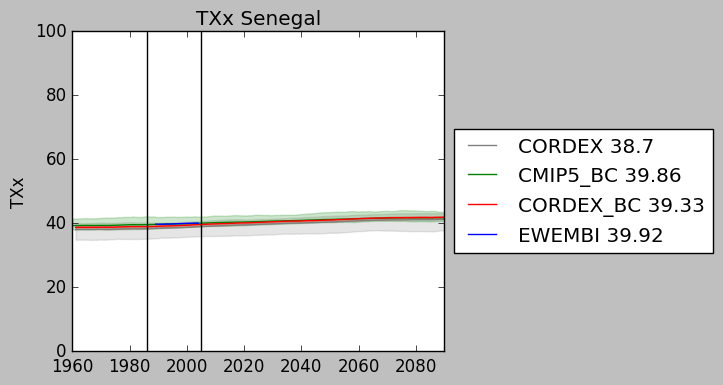

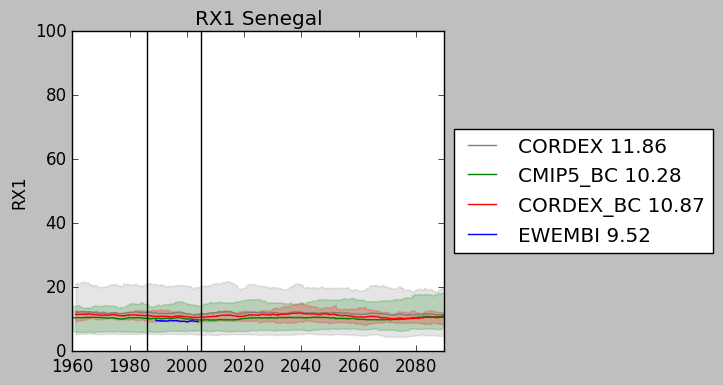

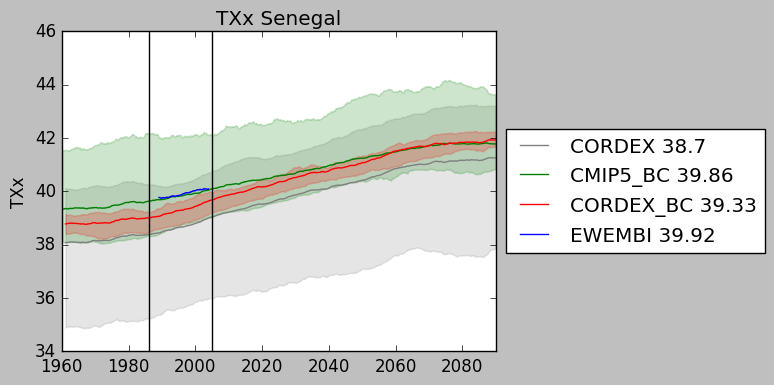

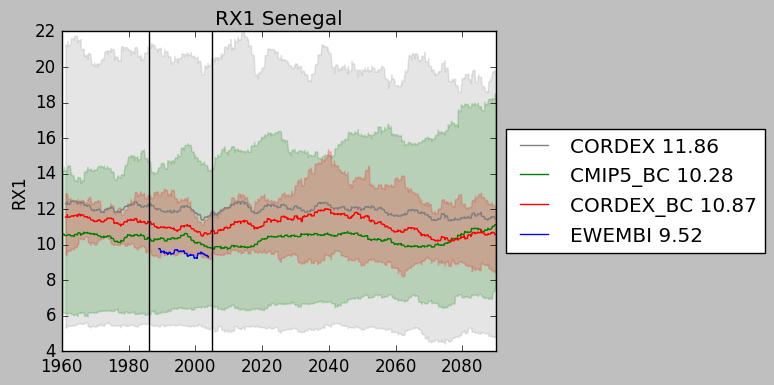

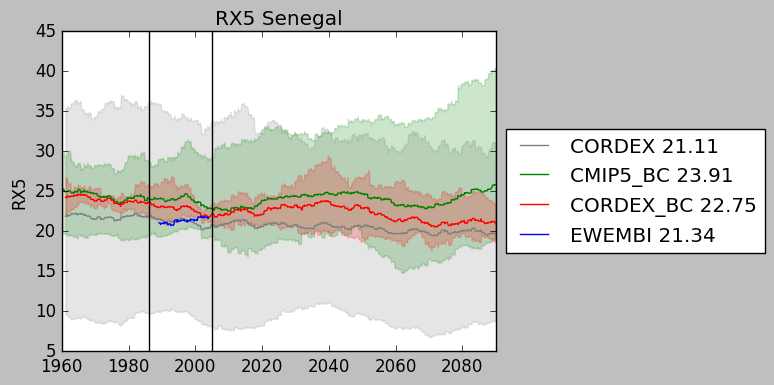

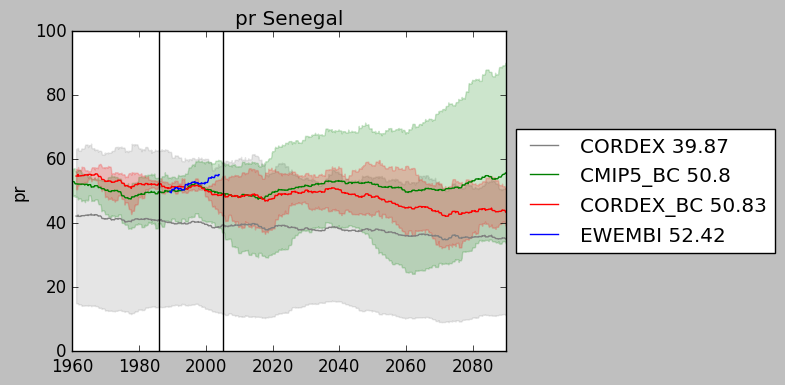

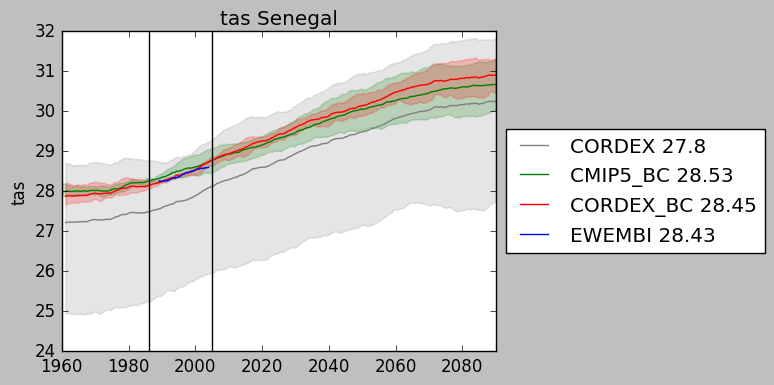

In [68]:
for indicator in ['TXx','RX1','RX5','pr','tas']:
    pr=COU.selection([indicator],show_selection=True)
    COU.area_average(selection=pr,mask_style='lat_weighted',overwrite=False)
    COU.unit_conversions()

    fig,ax = plt.subplots(nrows=1, ncols=1, figsize=(8,4))
    for i in [24,1,19,28]:
        ref_mean=np.nanmean(country_analysis.running_mean_func(pr[i].area_average['lat_weighted']['SEN'],240)[np.where((pr[i].year>=1989) & (pr[i].year<=2003))])
        pr[i].plot_transients(ax=ax,running_mean_years=20,
                              label=plot_dict[i]['label']+' '+str(round(ref_mean,2)),
                              color=plot_dict[i]['color'],shading_range=[0,100])
    ax.plot([1986,1986],ax.get_ylim(),'k')
    ax.plot([2005,2005],ax.get_ylim(),'k')

    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.7, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))   

    ax.set_title(indicator+' Senegal')
    plt.savefig(COU._working_directory+'plots/'+indicator+'_transients.png',dpi=300)
plt.show()

In [65]:
# Bias correction maps
COU.period_statistics(periods={'ref':[1986,2006]})
COU.period_model_agreement()

for indicator in ['TXx','RX1','RX5','pr','tas']:

    ens_BC=COU.find_ensemble([indicator,'CORDEX_BC'])
    ens_noBC=COU.find_ensemble([indicator,'CORDEX'])
    ens_cmip5=COU.find_ensemble([indicator,'CMIP5_BC'])
    ewembi=COU.selection([indicator,'EWEMBI'])[0]

    bias_corretion_check=COU._working_directory+'plots/'+indicator+'_BC_check.png'
    fig,axes=plt.subplots(nrows=4,ncols=6,figsize=(10,5))
    axes=axes.flatten()

    # find nice colorrange
    abs_boundary=[]
    for model in ens_BC['models'].values():
        to_plot=model.period['mean']['annual']['ref']-ewembi.period['mean']['annual']['ref']
        abs_boundary.append(max(abs(np.nanpercentile(to_plot,[25,75]))))

    color_range=[-max(abs_boundary),max(abs_boundary)]

    # plot ref
    for model,i in zip(ens_cmip5['models'].values()+[ens_cmip5['mean']],range(len(ens_cmip5['models'].values())+1)):
        to_plot=model.period['mean']['annual']['ref']-ewembi.period['mean']['annual']['ref']
        im,color_range=model.plot_map(to_plot=to_plot,ax=axes[i],title='',color_bar=False,color_range=color_range,color_palette=plt.cm.PiYG_r)
        axes[i].set_title(model.model,fontsize=8)

    for model,i in zip(ens_noBC['models'].values()+[ens_noBC['mean']],range(len(ens_noBC['models'].values())+1)):
        to_plot=model.period['mean']['annual']['ref']-ewembi.period['mean']['annual']['ref']
        im,color_range=model.plot_map(to_plot=to_plot,ax=axes[i+6],title='',color_bar=False,color_range=color_range,color_palette=plt.cm.PiYG_r)
        axes[i+6].set_title(model.model,fontsize=8)

    for model,i in zip(ens_BC['models'].values()+[ens_BC['mean']],range(len(ens_BC['models'].values())+1)):
        to_plot=model.period['mean']['annual']['ref']-ewembi.period['mean']['annual']['ref']
        im,color_range=model.plot_map(to_plot=to_plot,ax=axes[i+12],title='',color_bar=False,color_range=color_range,color_palette=plt.cm.PiYG_r)
        axes[i+12].set_title(model.model,fontsize=8)

    axes[0].set_ylabel('CMIP5\nBias-corrected')
    axes[6].set_ylabel('CORDEX')
    axes[12].set_ylabel('CORDEX\nBias-corrected')
    for i in [11,17,18,19,20,21,22,23]: axes[i].axis('off')

    if im!=0:
        cbar_ax=fig.add_axes([0.3,0.2,0.4,0.6])
        cbar_ax.axis('off')
        cb=fig.colorbar(im,orientation='horizontal',label='Precipitation')

        plt.suptitle('Model - EWEMBI over Refernce Period (1986-2006)')
        plt.savefig(bias_corretion_check,dpi=300)